In [1]:
import numpy as np
import gym
from gym import spaces
import random
import pandas as pd
import time
import tkinter as tk
from tkinter import * 

**action**:
* Đánh 1 cây cùng chất
* Đánh 2
* Đánh 1 đôi
* Đánh 1 bộ ba
* Đánh tứ quý

* Đánh dây 3
* Đánh dây 4
* Đánh dây 5
* Đánh dây 6
* Đánh dây 7
* Đánh dây 8
* Đánh dây 9
* Đánh dây 10
* Đánh dây 11
* Đánh dây 12
* Đánh dây 13

* Bỏ lượt

In [2]:
data_cards = ['3_bich', '3_nhep', '3_do', '3_co' , '4_bich', '4_nhep', '4_do', '4_co', '5_bich', '5_nhep', '5_do', '5_co', '6_bich', '6_nhep', '6_do', '6_co',  '7_bich', '7_nhep', '7_do', '7_co',  '8_bich', '8_nhep', '8_do', '8_co', '9_bich', '9_nhep', '9_do', '9_co', '10_bich', '10_nhep', '10_do', '10_co', 'j_bich', 'j_nhep', 'j_do', 'j_co',  'q_bich', 'q_nhep', 'q_do', 'q_co', 'k_bich', 'k_nhep', 'k_do', 'k_co',  'A_bich', 'A_nhep', 'A_do', 'A_co', '2_bich', '2_nhep', '2_do', '2_co']

In [3]:
data_actions = [
            'play_single',
            'play_two',
            'play_pair',
            'play_trio',
            'play_four_of_a_kind',
            'play_straight_3',
            'play_straight_4',
            'play_straight_5',
            'play_straight_6',
            'play_straight_7',
            'play_straight_8',
            'play_straight_9',
            'play_straight_10',
            'play_straight_11',
            'play_straight_12',
            'play_four_of_a_kind_to_two',
            'pass_turn']

In [4]:
values = ['3'] * 4 + ['4'] * 4 + ['5'] * 4 + ['6'] * 4 + ['7'] * 4 + ['8'] * 4 + ['9'] * 4 + ['10'] * 4 + \
         ['J'] * 4 + ['Q'] * 4 + ['K'] * 4 + ['A'] * 4 + ['2'] * 4
card_df = pd.DataFrame({'Value': values})
symbols = ['♠', '♣', '♢', '♡']
repeated_symbols = symbols * 13 
card_df['Symbol'] = repeated_symbols
card_df['Card'] = card_df.apply(lambda row: f"|{row['Value']}{row['Symbol']}|", axis=1)
card_df = card_df.drop(columns=['Value','Symbol'])
card_df

,Card
0,|3♠|
1,|3♣|
2,|3♢|
3,|3♡|
4,|4♠|
5,|4♣|
6,|4♢|
7,|4♡|
8,|5♠|
9,|5♣|


In [5]:
cards_data = pd.DataFrame(data_cards)
action_data = pd.DataFrame(data_actions)
action_data

,0
0,play_single
1,play_two
2,play_pair
3,play_trio
4,play_four_of_a_kind
5,play_straight_3
6,play_straight_4
7,play_straight_5
8,play_straight_6
9,play_straight_7


* mod 4 = 0 => bích
* mod 4 = 1 => nhép
* mod 4 = 2 => dô
* mod 4 = 3 => cơ


# Player

In [112]:
class player():
    def __init__(self):
        self.name = None
        self.idx = None
        self.priority = None
        self.cards = np.zeros(52,dtype=np.int8)
        self.valid_actions = np.zeros(17,dtype=np.int8)
        self.reward = 0
        self.num_hand_cards = np.sum(self.cards)
        self.current_played_cards = np.zeros(52,dtype=np.int8)
        self.is_skip = 0
        
    def get_played_cards_state(self):
        idx_first_card_played = np.argmax(self.current_played_cards)
        color = 0 if idx_first_card_played%4 <2 else 1
        material = idx_first_card_played % 4
        num_played = int(np.sum(self.current_played_cards))
        played_two = False
        if np.sum(self.current_played_cards[48:]) != 0:
            played_two = True
        
        # Kiểm tra dây
        indices = np.where(self.current_played_cards == 1)[0]

        if indices.size > 1 and  np.diff(indices)[0]!=1:
            differences = np.diff(indices)
            all_congruent = np.all(differences == differences[0])
        else:
            all_congruent = False
        if num_played == 3:
            played_trio = not all_congruent
            played_four = False
        elif num_played == 4:
            played_trio = False
            played_four = not all_congruent
        else:
            played_trio, played_four = False,False

        return idx_first_card_played, color, material, num_played,played_two, played_trio, played_four
    
    #__________________________________________Lấy đôi____________________________________________#
    
    def get_pair_on_hand(self):
        '''
        Hàm lấy đôi trên tay
        
        Return:
        idx_trio (numpy.array([int,int,int,...])) : int: chỉ số đầu tiên của mỗi đôi (0<int<51)
        color (numpy.array([int,int,int...]))     : int: màu tương ứng (0<int<2)
        
        color:
        int = 0: Đỏ
        int = 1: Đen

        '''
        idx_pair = []
        idx_color = []
        for i in range(0,52,2):
            if (self.cards[i],self.cards[i+1]) == (1,1):
                idx_pair = np.append(idx_pair,i)
                if i%4==0 or i%4==1:
                    idx_color = np.append(idx_color,0)
                else:
                    idx_color = np.append(idx_color,1)
        return np.array(idx_pair,dtype=np.int8),np.array(idx_color,dtype=np.int8)
    #__________________________________________Lấy tam____________________________________________#
    def get_trio_on_hand(self):
        
        '''
        Hàm lấy tam trên tay
        
        Return:
        idx_trio ( numpy.array([int,int,int],[int,int,int],....) ) : idx 3 cards, 0<int<52
        matertial_trio ( numpy.array([int,int,int],[int,int,int],....) ) : material trio on hand, 0<int<3
        material_played (numpy.array([int,int,int])) : material trio played,0<int<3
        material:
        int = 0: Bích
        int = 1: Nhép
        int = 2: Dô
        int = 3: Cơ
        
        '''
        idx_trio = []
        material_trio = []
        material_played_indices = np.where(self.current_played_cards != 0)[0]
        material_played = material_played_indices%4
        for i in range(0, 52, 4):
            if sum([self.cards[i], self.cards[i+1], self.cards[i+2], self.cards[i+3]]) == 4:
                first_trio = (i, i+1, i+2)
                second_trio = (i, i+1, i+3)
                third_trio = (i+1, i+2, i+3)
                fourth_trio = (i, i+2, i+3)

                first_material = (0, 1, 2)
                second_material = (0, 1, 3)
                third_material = (1, 2, 3)
                fourth_material = (0, 2, 3)

                idx_trio.extend([first_trio, second_trio, third_trio, fourth_trio])
                material_trio.extend([first_material, second_material, third_material, fourth_material])

            elif [self.cards[i], self.cards[i+1], self.cards[i+2]] == [1, 1, 1]:
                idx_trio.append((i, i+1, i+2))
                material_trio.append((0, 1, 2))

            elif [self.cards[i], self.cards[i+1], self.cards[i+3]] == [1, 1, 1]:
                idx_trio.append((i, i+1, i+3))
                material_trio.append((0, 1, 3))

            elif [self.cards[i+1], self.cards[i+2], self.cards[i+3]] == [1, 1, 1]:
                idx_trio.append((i+1, i+2, i+3))
                material_trio.append((1, 2, 3))

            elif [self.cards[i], self.cards[i+2], self.cards[i+3]] == [1, 1, 1]:
                idx_trio.append((i, i+2, i+3))
                material_trio.append((0, 2, 3))  

            i += 3
        return np.array(idx_trio,dtype=np.int8),np.array(material_trio,dtype=np.int8),np.array(material_played,dtype=np.int8)
    
    #__________________________________________Lấy tứ quý____________________________________________#
    
    def get_four_of_a_kind_on_hand(self):
        '''
        Hàm lấy té quý trên tay
        
        Return:
        idx_trio (numpy.array([int,int,int,...])) : int: chỉ số đầu tiên của mỗi tứ quý (0<int<49)

        '''
        idx_four = []
        for i in range(0,52,4):
            if np.sum([self.cards[i], self.cards[i+1],self.cards[i+2],self.cards[i+3]]) == 4:
                idx_four = np.append(idx_four, i)
                i += 3
        return np.array(idx_four,dtype=np.int8)
        
    #__________________________________________Lấy dây____________________________________________#
        
    def get_straight_on_hand(self,length):
        '''
        Hàm lấy dây trên tay
        
        Return:
        idx_straight (numpy.array([int,int,int,...])) : int: chỉ số đầu tiên của mỗi dây có độ dài length
        
        Parameters:
        length: độ dài dây 
        
        '''
        idx_straight = []
        if length <= 10:
            for i in range(52-length*5):
                if self.cards[i] == 1:
                    straight = [i]
                    idx_card_into_straight = i
                    for _ in range(length-1):
                        idx_card_into_straight += 4
                        if self.cards[idx_card_into_straight] == 1:
                            straight = np.append(straight, idx_card_into_straight)

                    if len(straight) == length:
                        idx_straight = np.append(idx_straight,straight[0])
        else:
            for i in range(4):
                elements = self.cards[i:48:4]
                if np.all(elements == 1):
                    idx_straight = np.append(idx_straight,i)
                    return np.array(idx_straight)
        return np.array(idx_straight)     
    
    #__________________________________________Lấy actions____________________________________________#
    
    def get_valid_action(self):
        if self.is_skip == 1:
            self.valid_actions[16] = 1
            return self.valid_actions
        idx_first_card_played, color_played,material_played, num_played,played_two,played_trio,played_four = self.get_played_cards_state()
        biggest_card = np.where(self.cards == 1)[0][-1]
        pair_to_play,color_to_play = self.get_pair_on_hand()
        trio_to_play, material_to_play,material_trio_played = self.get_trio_on_hand()
        if num_played == 0:
            self.valid_actions[0] = 1
            if biggest_card > 47:
                self.valid_actions[1] = 1
            if pair_to_play.size > 0:
                self.valid_actions[2] = 1
            if trio_to_play.size > 0:
                self.valid_actions[3] = 1
            if self.get_four_of_a_kind_on_hand().size > 0:
                self.valid_actions[4] = 1
            for i in range(3,13):
                if self.get_straight_on_hand(i).size > 0:
                    self.valid_actions[i+2] = 1
            return self.valid_actions

        
        
        
        elif num_played == 1:
            for idx_card_to_play in range(idx_first_card_played+1,48):
                if (idx_card_to_play%4 == material_played) and (self.cards[idx_card_to_play]==1):
                    self.valid_actions[0] = 1
                    break
            if (biggest_card > 47) and (biggest_card > idx_first_card_played):
                self.valid_actions[1] = 1
                
        elif num_played == 2:
            for idx_first_card_in_pair,color in zip(pair_to_play,color_to_play):
                if (idx_first_card_in_pair > idx_first_card_played) and (color == color_played):
                    self.valid_actions[2] = 1
                    break
        elif (num_played == 3) and played_trio:
            for trio,material in zip(trio_to_play,material_to_play):
                print(f'trio[0]:{trio[0]} > idx_first_c_p:{idx_first_card_played}, np.all:material:{material}==material_trio_played{material_trio_played}')
                if (trio[0] > idx_first_card_played) and np.all(material==material_trio_played) :
                    self.valid_actions[3] = 1
                    break
                    
        elif num_played == 4 and played_four:
            idx_four =  self.get_four_of_a_kind_on_hand()
            for idx in idx_four:
                if idx > idx_first_card_played:
                    self.valid_actions[4] = 1
                    break   
        elif num_played >= 3:
            straight_to_play = self.get_straight_on_hand(num_played)
            for straight in straight_to_play:
                if (straight > idx_first_card_played) and (straight%4==material_played):
                    self.valid_actions[num_played+2] = 1
                    break
        if num_played == 1 and played_two:
            idx_four =  self.get_four_of_a_kind_on_hand()
            for idx in idx_four:
                self.valid_actions[15] = 1
                break 
        self.valid_actions[16] =1
        return self.valid_actions

            
            

# ENVs

In [103]:
class TLMB_Env():
    def __init__(self):
        super(TLMB_Env, self).__init__()
        self.num_cards = 52
        self.num_players = 4
        self.num_cards_per_player = 13
        
        self.agent = player()
        self.pc_player1 = player()
        self.pc_player2 = player()
        self.pc_player3 = player()
        
        self.agent.name = 'Agent'
        self.pc_player1.name = 'PC1'
        self.pc_player2.name = 'PC2'
        self.pc_player3.name = 'PC3'
        
        self.agent.idx = 0
        self.pc_player1.idx = 1
        self.pc_player2.idx = 2
        self.pc_player3.idx = 3
        
        self.all_players = [self.agent,self.pc_player1,self.pc_player2,self.pc_player3]
        self.num_skip = 0
        
        self.current_played_cards = np.zeros(52,dtype=np.int8)
        self.all_rewards = [0,0,0,0]
        
        self.turn = 0
        self.current_player = None
        
        self.root = None
        self.label_cards = None
        
        self.i_current_cards = 0
        
        self.actions=['play_single',
                      'play_two',
                      'play_pair',
                      'play_trio',
                      'play_four_of_a_kind',
                      'play_straight_3',
                      'play_straight_4',
                      'play_straight_5',
                      'play_straight_6',
                      'play_straight_7',
                      'play_straight_8',
                      'play_straight_9',
                      'play_straight_10',
                      'play_straight_11',
                      'play_straight_12',
                      'play_four_of_a_kind_to_two',
                      'pass_turn'
                      ]        
        
        
    def reset(self):
        #_____________________________________________Chia bài________________________________________________#
        deck = np.arange(self.num_cards)
        np.random.shuffle(deck)
        
        for i,player in enumerate(self.all_players):
            player.cards[deck[i * self.num_cards_per_player:(i + 1) * self.num_cards_per_player]] = 1
        
        #_____________________________________________Thứ tự đánh_____________________________________________#
        priority = (np.where(deck == 0)[0][0])//13
        self.current_player = self.all_players[priority]
            
        self.reset_current_played_cards()
        
        #_____________________________________________Hiển thị_____________________________________________#
        self.root = self.init_display()
        self.display()
            
    def init_display(self):
        suits = ['♠', '♣', '♢', '♡']  
        values = ['3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A','2']
        all_cards = [f'{value}{suit}' for value in values for suit in suits]
        self.label_cards = np.array([])
        self.root = tk.Tk()
        self.root.title("1 game")
        self.root.geometry('1000x800')
        self.root.resizable(0,0)
        self.root.configure(bg='#1b62a8')
        for idx, card in enumerate(all_cards):
            if idx%4 in (0,1):
                label = tk.Label(self.root, text=card, font=('Arial', 20), relief='solid', width=3, height=2)
            else:
                label = tk.Label(self.root, text=card, font=('Arial', 20),fg='red', relief='solid', width=3, height=2)

            self.label_cards = np.append(self.label_cards,label)
        self.label_turn = tk.Label(self.root,text='🃏',bg='#34eb49' ,font=('Arial',30))
        return self.root
    def display(self):
        self.root.withdraw()
        #______________________________________________SKIP______________________________________#
        all_skip = [p.is_skip for p in self.all_players]
        skip_place = [(520,600),(850,320),(430,75),(125,430)]
        for i,skip in enumerate(all_skip):
            if skip == 1:
                skip_label = tk.Label(self.root, text='👐',fg='black',bg='#cdd402',font=('Arial',20,'bold'))
            else:
                skip_label = tk.Label(self.root, text='👍',fg='black',bg='#cdd402',font=('Arial',20,'bold'))
            skip_label.place(x=skip_place[i][0],y=skip_place[i][1],anchor='nw')
        #____________________________________________TURN_________________________________________#
        dic_turn_place = [(475,600),(850,372.5),(475,75),(105,372.5)]
        current_index = self.all_players.index(self.current_player)
        place = dic_turn_place[current_index]
        self.label_turn.place(x=place[0],y=place[1])
        
        #__________________________________________Num,Name_______________________________________#
        all_num_cards = [np.sum(p.cards) for p in self.all_players]
        all_names = [p.name for p in self.all_players]
        inf_place = [(575,615),(780,270),(300,80),(100,480)]
        i = 0
        for num,name in zip(all_num_cards,all_names):
            p_inf_label = tk.Label(self.root, text=f'{name}, num cards: {num}')
            p_inf_label.place(x=inf_place[i][0],y=inf_place[i][1],anchor='nw')
            i+=1
        
        #__________________________________________HAND-CARD______________________________________#
        i_human = 0
        for idx_card,value in enumerate(self.agent.cards):
            if value == 1:
                self.label_cards[idx_card].place(x=150+i_human*50,y=650,anchor='nw')
                i_human+=1
        i_pc1 = 0
        for idx_card,value in enumerate(self.pc_player1.cards):
            if value == 1:
                self.label_cards[idx_card].place(x=900,y=80+i_pc1*45,anchor='nw')
                i_pc1+=1
        i_pc2 = 0
        for idx_card,value in enumerate(self.pc_player2.cards):
            if value == 1:
                self.label_cards[idx_card].place(x=150+i_pc2*50,y=5,anchor='nw')
                i_pc2+=1
        i_pc3 = 0
        for idx_card,value in enumerate(self.pc_player3.cards):
            if value == 1:
                self.label_cards[idx_card].place(x=30,y=80+i_pc3*45,anchor='nw')
                i_pc3+=1

        for idx_card,value in enumerate(self.current_played_cards):
            if value == 1:
                self.label_cards[idx_card].place(x=300+self.i_current_cards*30,y=300,anchor='nw')
                self.i_current_cards+=1
        self.root.after(0, self.root.deiconify)
        next_button = tk.Button(self.root,text='Chuyển lượt',command=self.root.quit)
        next_button.place(x=900,y=700)
        self.root.mainloop()
        
    def reset_current_played_cards(self):
        self.current_played_cards = np.zeros(52,dtype=np.int8)
    
    def check_end_round(self):
        num_skip = 0
        for p in self.all_players:
            num_skip += p.is_skip
        if num_skip == 3:
            print('Bỏ hết lượt')
            return True
        return False
    
    def check_victory(self):
        for p in self.all_players:
            if np.sum(p.cards) == 0:
                print(f'Player`s {p.name} win the game')
                return True
        return False
    

        
    def next_player(self):
        current_index = self.all_players.index(self.current_player)
        next_index = (current_index + 1) % 4
        return self.all_players[next_index]

    
    def step(self, player, action):        
        reward = 0
        done = False
        
        #update bài vừa đánh
        for p in self.all_players:
            p.current_played_cards = self.current_played_cards
        played_cards = self.current_played_cards
            
        idx_first_card_played, color_played, material_played, num_played,played_two,played_trio,played_four = player.get_played_cards_state()
        idx = []
        print(f'num_played:{num_played}')
        
        current_index = self.all_players.index(self.current_player)
        print(f'CURRENT PLAYER:{self.current_player.name},idx :{current_index}')
        if self.actions[action] == 'play_single':
            if num_played == 0:
                    idx = np.argmax(player.cards)
                    player.cards[idx] = 0
                    self.reset_current_played_cards()
                    self.current_played_cards[idx] = 1
                    reward = 1
            else:
                for idx_card_to_play in range(idx_first_card_played+1,48):
                    if (idx_card_to_play%4 == material_played) and (player.cards[idx_card_to_play]==1):
                        # Đánh cây nhỏ nhất có thể
                        idx = idx_card_to_play
                        player.cards[idx] = 0
                        self.reset_current_played_cards()
                        self.current_played_cards[idx] = 1
                        reward = 1
                        break
            
        elif self.actions[action] == 'play_two':                                 
            idx_card_played = np.argmax(self.current_played_cards)
            idx_card_to_play = np.argmax(player.cards[48:] == 1) + 48
                                           # Đánh cây nhỏ nhất có thể                                 
            idx = idx_card_to_play
            player.cards[idx] = 0
            self.reset_current_played_cards()
            self.current_played_cards[idx] = 1
            reward = 1
            
        elif self.actions[action] == 'play_pair':                 
            pair_to_play,color_to_play = player.get_pair_on_hand()
            for idx_first_card_in_pair,color in zip(pair_to_play,color_to_play):
                if ((idx_first_card_in_pair > idx_first_card_played) and (color == color_played))or(num_played==0):
                    print(f'first card in pair: {idx_first_card_in_pair}')
                    idx = [idx_first_card_in_pair,idx_first_card_in_pair+1]
                    player.cards[idx] = [0,0]
                    self.reset_current_played_cards()
                    self.current_played_cards[idx] = [1,1]
                    reward = 2
                    break
            
        elif self.actions[action] == 'play_trio':
            trio_to_play, material_to_play,material_trio_played = player.get_trio_on_hand()
            for trio,material in zip(trio_to_play,material_to_play):
                print(f'Trường hợp chơi tam: tam trên tay:{get_display_card(trio_to_play)}, tam đã đánh:{get_display_card(idx_first_card_played)}')
                if ((trio[0] > idx_first_card_played) and np.all(material==material_trio_played))or(num_played==0) :
                    idx = trio
                    player.cards[idx] = [0,0,0]
                    self.reset_current_played_cards()
                    self.current_played_cards[idx] = [1,1,1]
                    reward = 3
                    break
            reward = 3
            
        elif self.actions[action] == 'play_four_of_a_kind':
            idx_four =  player.get_four_of_a_kind_on_hand()
            for idx_ in idx_four:
                print(f'Tứ quí trên tay:{card_df.iloc[[idx_,idx_+1,idx_+2,idx_+3],0].values}')
                if (idx_ > idx_first_card_played)or(num_played==0):
                    idx = [idx_,idx_+1,idx_+2,idx_+3]
                    player.cards[idx] = [0,0,0,0]
                    self.reset_current_played_cards()
                    self.current_played_cards[idx] = [1,1,1,1]
                    break   
            reward = 4
            
        elif action in range(5,15):         # play_straight
            length_straight = num_played
            straight_to_play = player.get_straight_on_hand(length_straight)
            print(f'trường hợp đánh dây, số bài đã đánh trước đó: {num_played}')
            for straight in straight_to_play:
                if ((straight > idx_first_card_played) and (straight%4==material_played))or(num_played==0):
                    idx = np.arange(straight, straight + 4 * (length_straight+1), 4)
                    print(f'Dây trên tay: {card_df.iloc[[idx],0].values}')
                    player.cards[idx] = np.zeros(length_straight)
                    self.reset_current_played_cards()
                    self.current_played_cards[idx] = np.ones(length_straight)
                    reward = length_straight
            
        elif self.actions[action] == 'play_four_of_a_kind_to_two':
            idx_four =  self.get_four_of_a_kind_on_hand()
            for idx_ in idx_four:
                idx = [idx_,idx_+1,idx_+2,idx_+3]
                player.cards[idx] = np.zeros(4)
                self.reset_current_played_cards()
                self.current_played_cards[idx] = np.ones(4)
                reward = 4
            
        elif self.actions[action] == 'pass_turn':
            player.is_skip = 1
            reward = 0
        #_____________________________________CẬP NHẬT LÁ BÀI ĐÃ ĐÁNH TRÊN MỖI PLAYER___________________________#
        for p in self.all_players:
            p.current_played_cards = self.current_played_cards
            
            
        #___________________________________CHECK END VÀ CHUYỂN NGƯỜI CHƠI TIẾP_________________________________#
        done = self.check_victory()
        end_round = self.check_end_round()
        prev_player = player
        if end_round:
            self.reset_current_played_cards()
            for p in self.all_players:
                if p.is_skip == 0:
                    self.current_player = p
                else:
                    p.is_skip = 0
            self.display()
            return
        self.current_player = self.next_player()
            
#         if done:
#             reward = self._calculate_final_rewards()

        #_____________________________________________Hiển thị_____________________________________________#
        print(f'Action: {action_data.iloc[action,0]}')
        print(f'PLAYED: {get_display_card(played_cards)}')
        print(f'{player.name} play: {card_df.iloc[idx,0]}')
        print(f'SWAP turn from {prev_player.name} to {self.current_player.name}')
        self.display()
        


    def _calculate_final_rewards(self):
        rewards = [-10 * np.sum(hand) for hand in self.player_hands]
        rewards[self.current_player] += 100 
        return rewards[self.current_player]

            

In [ ]:
my_object = TLMB_Env()
all_attributes = dir(TLMB_Env)
methods = [attribute for attribute in all_attributes if callable(getattr(TLMB_Env, attribute)) and not attribute.startswith('__')]
methods


# Kiểm tra lại skip

# Start

In [137]:
def get_display_card(arr):
    return card_df.iloc[np.where(arr == 1)[0],0].values

In [140]:
envs = TLMB_Env()

In [ ]:
envs.reset()
while envs.check_victory:
    player_ = envs.current_player
    actions = player_.get_valid_action()
    action = np.random.choice(np.where(actions == 1)[0])
    envs.step(player_,action)
    print(f'{player_.name} valid action:{action_data.iloc[np.where(actions == 1)[0]]}')
    print('_________________________________________________________________')
    card_a = get_display_card(envs.agent.cards)
    card_1 = get_display_card(envs.pc_player1.cards)
    card_2 = get_display_card(envs.pc_player2.cards)
    card_3 = get_display_card(envs.pc_player3.cards)

    print(f'agent:{card_a}\np1:{card_1},\np2:{card_2},\np3:{card_3}')

num_played:0
CURRENT PLAYER:PC2,idx :2
Action: play_two
PLAYED: []
PC2 play: |2♣|
SWAP turn from PC2 to PC3
PC2 valid action:             0
0  play_single
1     play_two
_________________________________________________________________
agent:['|3♣|' '|3♡|' '|6♠|' '|6♢|' '|7♡|' '|8♣|' '|9♢|' '|9♡|' '|J♣|' '|J♢|'
 '|K♣|' '|A♣|' '|A♡|']
p1:['|4♢|' '|4♡|' '|5♠|' '|5♣|' '|7♢|' '|8♢|' '|10♠|' '|10♣|' '|J♡|' '|Q♠|'
 '|Q♣|' '|Q♢|' '|K♡|'],
p2:['|3♠|' '|4♠|' '|5♢|' '|7♠|' '|8♠|' '|8♡|' '|10♡|' '|J♠|' '|Q♡|' '|K♠|'
 '|K♢|' '|2♢|'],
p3:['|3♢|' '|4♣|' '|5♡|' '|6♣|' '|6♡|' '|7♣|' '|9♠|' '|9♣|' '|10♢|' '|A♠|'
 '|A♢|' '|2♠|' '|2♡|']
num_played:1
CURRENT PLAYER:PC3,idx :3
Action: play_two
PLAYED: ['|2♣|']
PC3 play: |2♠|
SWAP turn from PC3 to Agent


# Bỏ lượt đầu rồi nhưng sau đó vẫn đánh được

# Lỗi play_single vẫn đánh được khi bài trước đó đánh 2 => action không thực hiện được

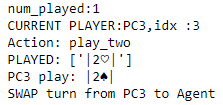

2 bích lớn hơn 2 cơ?

# Test

In [127]:
envs = TLMB_Env()

In [128]:
current_played_cards = np.zeros(52,dtype=np.int8)
current_played_cards[[33,34,35]] = [1,1,1]

In [129]:
cards = np.zeros(52,dtype=np.int8)
cards[[45,46,47]] = [1,1,1]

In [130]:
envs.pc_player2.cards = cards

In [131]:
envs.pc_player2.get_trio_on_hand()


(array([[45, 46, 47]], dtype=int8),
 array([[1, 2, 3]], dtype=int8),
 array([], dtype=int8))

In [132]:
envs.current_played_cards = current_played_cards
envs.current_played_cards 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [133]:
envs.pc_player2.current_played_cards = current_played_cards
envs.pc_player2.current_played_cards 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [134]:
envs.current_played_cards

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [135]:
envs.pc_player2.cards

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0], dtype=int8)

In [136]:
envs.pc_player2.get_valid_action()

trio[0]:45 > idx_first_c_p:33, np.all:material:[1 2 3]==material_trio_played[1 2 3]


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int8)

In [122]:
action_data

,0
0,play_single
1,play_two
2,play_pair
3,play_trio
4,play_four_of_a_kind
5,play_straight_3
6,play_straight_4
7,play_straight_5
8,play_straight_6
9,play_straight_7


In [35]:
card_df

,Card
0,|3♠|
1,|3♣|
2,|3♢|
3,|3♡|
4,|4♠|
5,|4♣|
6,|4♢|
7,|4♡|
8,|5♠|
9,|5♣|


In [ ]:
cards = np.random.randint(2, size=52)
cards_data[0][cards == 1].values

In [ ]:
# Các giá trị đầu vào
idx = 2       # chỉ số bắt đầu
length = 10   # độ dài của mảng

np.arange(idx, idx + 4 * length, 4)

In [ ]:
cards = np.ones(52,dtype=np.int8)

In [ ]:
cards = np.zeros(52,dtype=np.int8)
cards[[1,5,9,13]] = 1

In [ ]:
current_played_cards = np.zeros(52,dtype=np.int8)
current_played_cards[[0,4,8,12]] = 1

In [ ]:
player1 = player()
player1.cards = cards
player1.current_played_cards = current_played_cards
player1.valid_action = player1.get_valid_action()
action_valid = player1.valid_action 
action_data[0][action_valid == 1].values

In [ ]:
values = ['3'] * 4 + ['4'] * 4 + ['5'] * 4 + ['6'] * 4 + ['7'] * 4 + ['8'] * 4 + ['9'] * 4 + ['10'] * 4 + \
         ['J'] * 4 + ['Q'] * 4 + ['K'] * 4 + ['A'] * 4 + ['2'] * 4
card_df = pd.DataFrame({'Value': values})
symbols = ['♠', '♣', '♡', '♢']
repeated_symbols = symbols * 13 
card_df['Symbol'] = repeated_symbols
card_df['Card'] = card_df.apply(lambda row: f"|{row['Value']}{row['Symbol']}|", axis=1)
card_df = card_df.drop(columns=['Value','Symbol'])
card_df

In [ ]:
action_data

In [ ]:
biggest_card = np.where(cards == 1)[0]
biggest_card_not_two = np.where(cards[:48] == 1)[0]
biggest_card,biggest_card_not_two